In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import *
import pandas_datareader.data as web
import numexpr as ne
from datetime import datetime
!pip install yfinance
import yfinance as yf
import backtrader as bt

# Speed

In [6]:
# method 1
loops = 25000000
a = range(1, loops)
def f(x):
    return 3 * log(x) + cos(x) ** 2
%timeit r = [f(x) for x in a]

12.8 s ± 2.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# method 2
a = np.arange(1, loops)
%timeit r = 3 * np.log(a) + np.cos(a) ** 2

585 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# method 3
ne.set_num_threads(1)
f = '3 * log(a) + cos(a) ** 2'
%timeit r = ne.evaluate(f)

250 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
import multiprocessing
multiprocessing.cpu_count()

8

In [15]:
# method 4
import numexpr as ne
ne.set_num_threads(8)
f = '3 * log(a) + cos(a) ** 2'
%timeit r = ne.evaluate(f)

99.6 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [127]:
import yfinance as yf
sp500= yf.download("^GSPC", start="2021-01-01", end="2021-11-09",group_by="ticker") 
sp500.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,3733.270020,3760.199951,3726.879883,3756.070068,3756.070068,3172510000
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5006680000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4582620000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6049970000
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5080870000


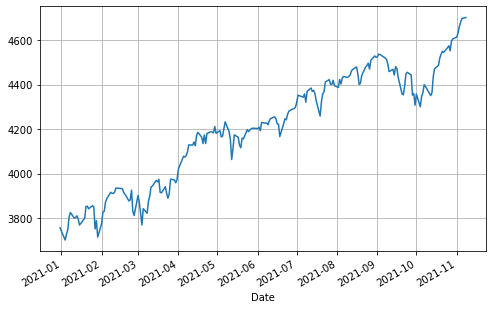

In [128]:
sp500['Close'].plot(grid=True, figsize=(8, 5))

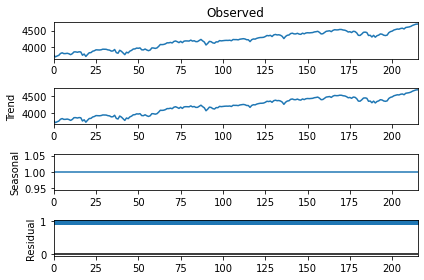

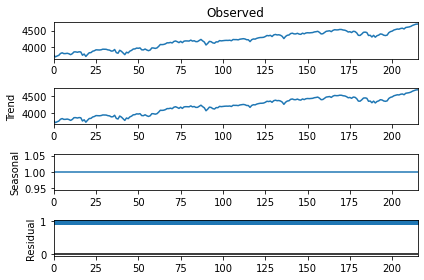

In [282]:
# Decomposing price
df=sp500['Close'].values
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_results = seasonal_decompose(df,model='multiplicative',period=1)
decomposition_results.plot()

In [ ]:
#Note
# Additive model
#y(t) = Level + Trend + Seasonality + Noise
#Multiplicative Model
# y(t) = Level * Trend * Seasonality * Noise
# As you can see that we are not able to seperate the noise, seasonality ( Straight line).
# Hence stichastic models are to be used.

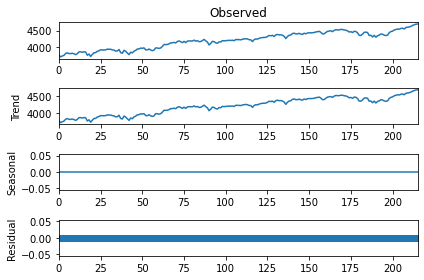

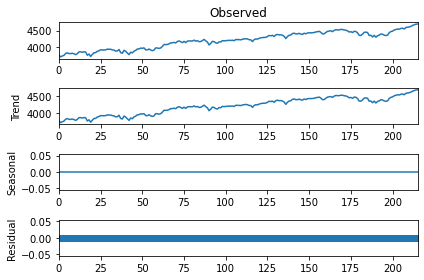

In [283]:
# Decomposing price
df=sp500['Close'].values
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_results = seasonal_decompose(df,model='additive',period=1)
decomposition_results.plot()

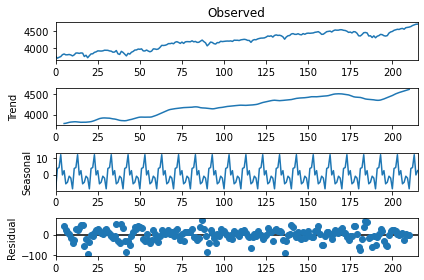

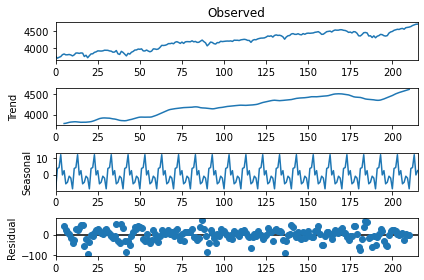

In [284]:
# Decomposing price with period set to 10
df=sp500['Close'].values
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_results = seasonal_decompose(df,model='additive',period=10)
decomposition_results.plot()

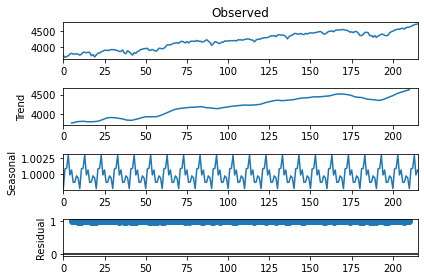

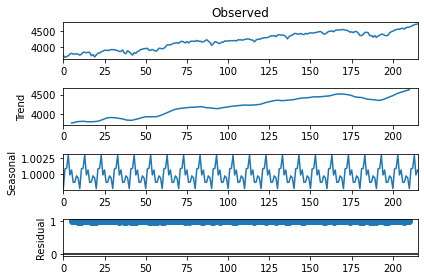

In [285]:
# Decomposing price with period set to 10
df=sp500['Close'].values
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_results = seasonal_decompose(df,model='multiplicative',period=10)
decomposition_results.plot()

In [ ]:
# Multiple period values can be tried for modelling

In [150]:
sp500['42d'] = np.round(sp500['Close'].rolling(42).mean(), 2)
sp500['90d'] = np.round(sp500['Close'].rolling(84).mean(), 2)

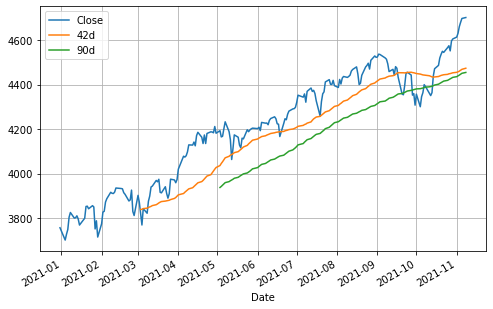

In [151]:
sp500[['Close', '42d', '90d']].plot(grid=True, figsize=(8, 5))

In [152]:
sp500['42-90'] = sp500['42d'] - sp500['90d']

In [168]:
SD = 30
sp500['Regime'] = np.where(sp500['42-90'] > SD, 1, 0)
sp500['Regime'] = np.where(sp500['42-90'] < -SD, -1, sp500['Regime'])
sp500['Regime'].value_counts()

1    121
0     95
Name: Regime, dtype: int64

In [169]:
# On value_count(1) days the 42d trend was more than SD points above 252d trend
# On value_count(-1) days the 42d trend was below more than SD points below 252d trend


(-1.1, 1.1)

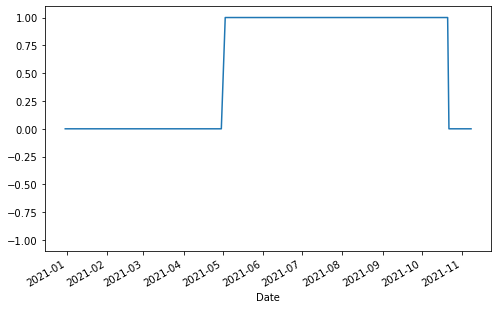

In [170]:
sp500['Regime'].plot(lw=1.5, figsize=(8, 5))
plt.ylim([-1.1, 1.1])


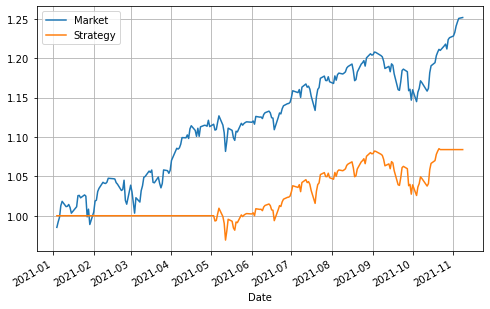

In [171]:
# Sample Strategy not good (Market is very bullish as it is :)
# This strategy is better during bearish markets
sp500['Market'] = np.log(sp500['Close'] / sp500['Close'].shift(1))
sp500['Strategy'] = sp500['Regime'].shift(1) * sp500['Market']
sp500[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True,figsize=(8, 5))


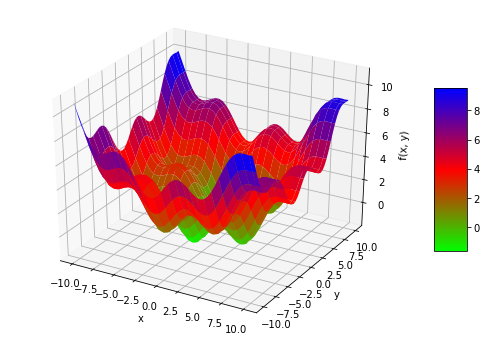

In [189]:
# Example of convex optimization
# Read further Global and local optimization
def fm(x, y):
     return (np.sin(x) + 0.05 * x ** 2 + np.sin(y) + 0.05 * y ** 2)
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)
X, Y = np.meshgrid(x, y)
Z = fm(X, Y)
fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=2, cstride=2,
                       cmap='brg_r',linewidth=0.5, 
                       antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
fig.colorbar(surf, shrink=0.5, aspect=5)


In [ ]:
# From this graph a global minima cannot be confirmed

In [210]:
# Black_scholes_merton_setup
import numpy.random as npr
S0 = 100 # initial value
r = 0.05 # constant short rate
sigma = 0.25 # constant volatility
T = 2.0 # in years
I = 10000 # number of random draws
ST1 = S0 * np.exp((r - 0.5 * sigma ** 2) * T
                  + sigma * np.sqrt(T) * npr.standard_normal(I))

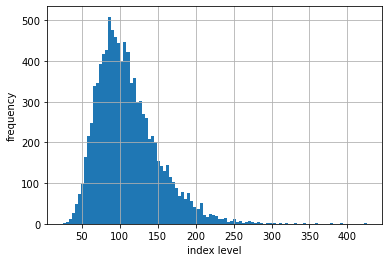

In [211]:
plt.hist(ST1, bins=100)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)

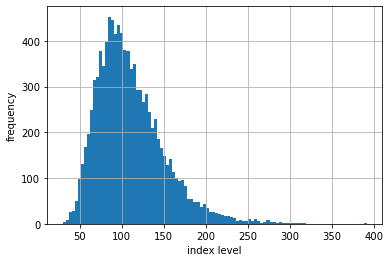

In [212]:
ST2 = S0 * npr.lognormal((r - 0.5 * sigma ** 2) * T,
                         sigma * np.sqrt(T), size=I)
# As the abive graph follows a lognormal distribution let us try to directly derive thr values for the random variable
plt.hist(ST2, bins=100)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)


In [220]:
# Both the distributions look same, but are they same
import scipy.stats as scs
def print_statistics(a1, a2):
     sta1 = scs.describe(a1)
     sta2 = scs.describe(a2)
     print('statistic', 'data set 1', 'data set 2')
     print(('size', sta1[0], sta2[0]))
     print(('min', sta1[1][0], sta2[1][0]))
     print(('max', sta1[1][1], sta2[1][1]))
     print(('mean', sta1[2], sta2[2]))
     print(('std', np.sqrt(sta1[3]),np.sqrt(sta2[3])))
     print(('skew', sta1[4], sta2[4]))
     print(('kurtosis', sta1[5], sta2[5]))


In [221]:
print_statistics(ST1, ST2)

statistic data set 1 data set 2
('size', 10000, 10000)
('min', 24.564749036999903, 29.258207383568706)
('max', 425.65837715512976, 391.9452830156978)
('mean', 110.62294989655452, 109.95199442973251)
('std', 40.68207548811371, 39.93089290796986)
('skew', 1.159117313634092, 1.105465237594882)
('kurtosis', 2.5293178572659247, 1.9681051097701943)


In [222]:
# Very different

In [224]:
I = 10000
M = 50
dt = T / M
S = np.zeros((M + 1, I))
S[0] = S0
for t in range(1, M + 1):
    S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt
                         + sigma * np.sqrt(dt) * npr.standard_normal(I))


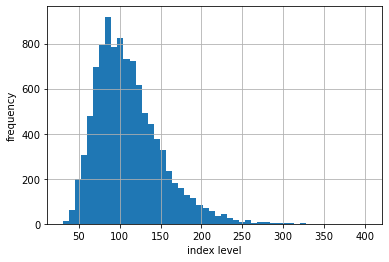

In [225]:
plt.hist(S[-1], bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)


In [226]:
print_statistics(S[-1], ST2)


statistic data set 1 data set 2
('size', 10000, 10000)
('min', 29.888177674140053, 29.258207383568706)
('max', 402.65752161385694, 391.9452830156978)
('mean', 110.47262126627038, 109.95199442973251)
('std', 40.169663497405985, 39.93089290796986)
('skew', 1.082837091077368, 1.105465237594882)
('kurtosis', 1.9084416704541907, 1.9681051097701943)


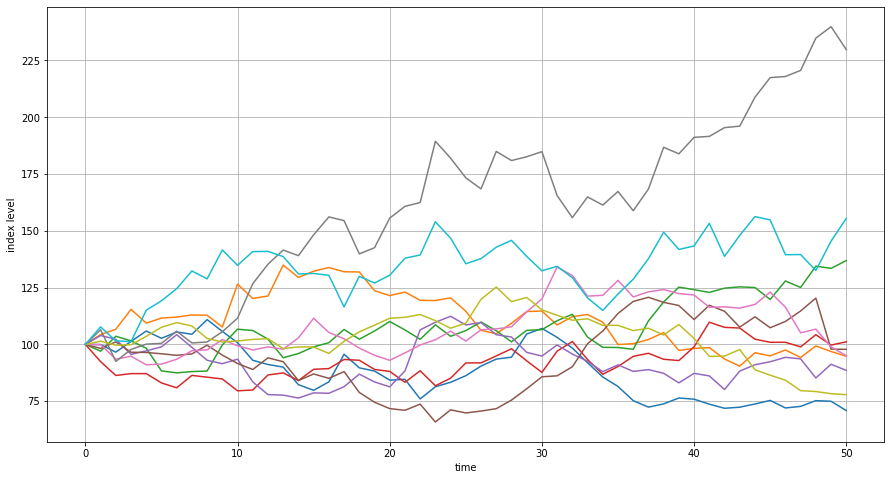

In [239]:
# First 10 simulations
plt.figure(figsize=(15,8))
plt.plot(S[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)

In [230]:
# Square root diffusion method
x0 = 0.05
kappa = 3.0
theta = 0.02
sigma = 0.1

I = 10000
M = 50
dt = T / M
def srd_euler():
    xh = np.zeros((M + 1, I))
    x1 = np.zeros_like(xh)
    xh[0] = x0
    x1[0] = x0
    for t in range(1, M + 1):
        xh[t] = (xh[t - 1]
            + kappa * (theta - np.maximum(xh[t - 1], 0)) * dt
            + sigma * np.sqrt(np.maximum(xh[t - 1], 0)) * np.sqrt(dt)
            * npr.standard_normal(I))
    x1 = np.maximum(xh, 0)
    return x1
x1 = srd_euler()


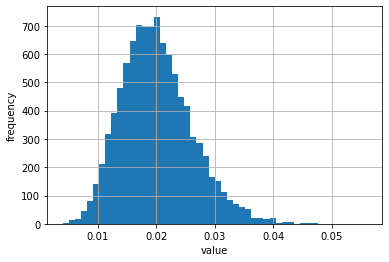

In [231]:
plt.hist(x1[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)


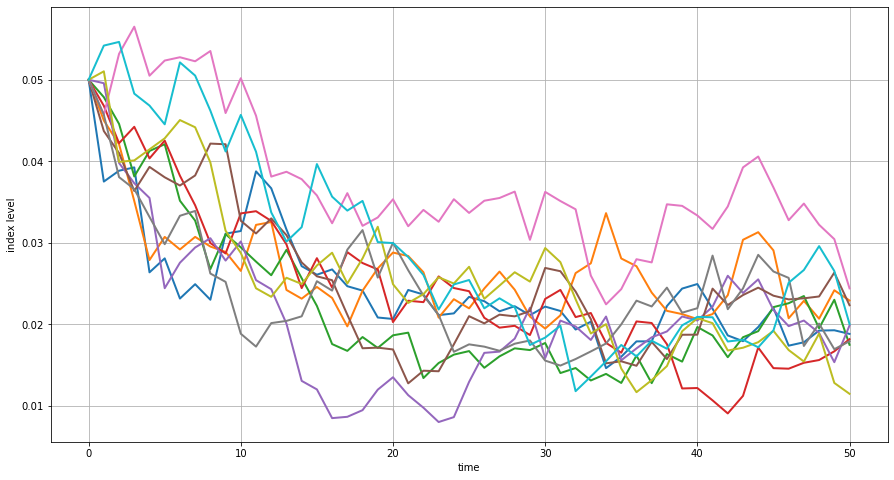

In [238]:
# Fierst 10 simulated paths
plt.figure(figsize=(15,8))
plt.plot(x1[:, :10], lw=2)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)


In [240]:
# Exact discretization for square root diffusion
def srd_exact():
     x2 = np.zeros((M + 1, I))
     x2[0] = x0
     for t in range(1, M + 1):
            df = 4 * theta * kappa / sigma ** 2
            c = (sigma ** 2 * (1 - np.exp(-kappa * dt))) / (4 * kappa)
            nc = np.exp(-kappa * dt) / c * x2[t - 1]
            x2[t] = c * npr.noncentral_chisquare(df, nc, size=I)
     return x2
x2 = srd_exact()

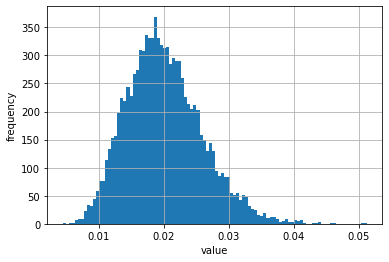

In [242]:
plt.hist(x2[-1], bins=100)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)

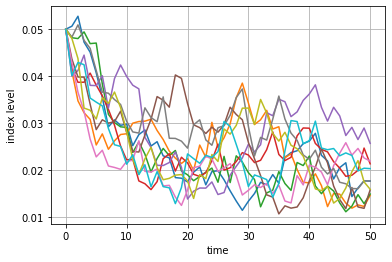

In [244]:
# First 10 simulated  paths
plt.plot(x2[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)


In [245]:
# COmparing the different approaches
print_statistics(x1[-1], x2[-1])

statistic data set 1 data set 2
('size', 10000, 10000)
('min', 0.004006515670114456, 0.004408352196993982)
('max', 0.055953140772723405, 0.05123110050144493)
('mean', 0.020087672873404846, 0.020068606360150367)
('std', 0.006018969288554742, 0.0058063995251135024)
('skew', 0.5604731525118914, 0.5465602059535397)
('kurtosis', 0.513174556465454, 0.5029834535599877)


In [247]:
I = 100000
%time x1 = srd_euler()

I = 100000
%time x2 = srd_exact()


Wall time: 194 ms
Wall time: 351 ms


In [248]:
# However, a major difference can be observed in terms of execution speed, since sampling
# from the noncentral chi-square distribution is more computationally demanding than
# from the standard normal distribution.

In [286]:
# heston stochastic validity model
# One of the over simplified assumption of the black-scholes model is the that volatility is constant
# Heston's model overcame this as volatility itself is desribed by a brownian

In [287]:
# heston stochastic validity model
S0 = 100.
r = 0.05
v0 = 0.1
kappa = 3.0
theta = 0.25
sigma = 0.1
rho = 0.6
T = 1.0
#To account for the correlation between the two stochastic processes,use cholsesky matrix
#Cholesky decomposition of the correlation matrix:
corr_mat = np.zeros((2, 2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)

array([[1. , 0. ],
       [0.6, 0.8]])

In [288]:
cho_mat

array([[1. , 0. ],
       [0.6, 0.8]])

In [289]:
M = 50
I = 10000
# Volatility model made using Square-root diffusion method
ran_num = npr.standard_normal((2, M + 1, I))
dt = T / M
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)
v[0] = v0
vh[0] = v0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    vh[t] = (vh[t - 1] + kappa * (theta - np.maximum(vh[t - 1], 0)) * dt
         + sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * np.sqrt(dt)* ran[1])
v = np.maximum(vh, 0)

In [290]:
# For index level process
# USe excat euler scheme for geometric brownian
S = np.zeros_like(ran_num[0])
S[0] = S0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt +
        np.sqrt(v[t]) * ran[0] * np.sqrt(dt))


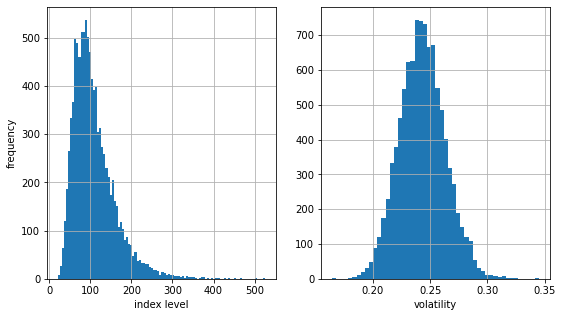

In [293]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
ax1.hist(S[-1], bins=100)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax1.grid(True)
ax2.hist(v[-1], bins=50)
ax2.set_xlabel('volatility')
ax2.grid(True)

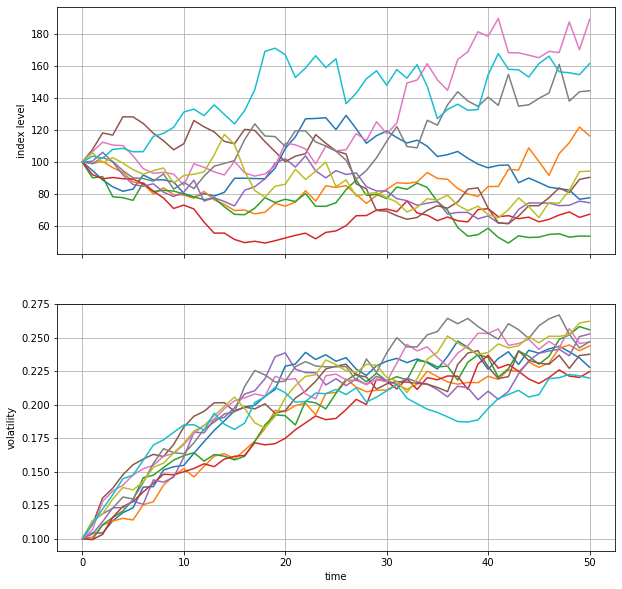

In [296]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
ax1.plot(S[:, :10], lw=1.5)
ax1.set_ylabel('index level')
ax1.grid(True)
ax2.plot(v[:, :10], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('volatility')
ax2.grid(True)


In [297]:
print_statistics(S[-1], v[-1])

statistic data set 1 data set 2
('size', 10000, 10000)
('min', 20.24592792029785, 0.1640741463942648)
('max', 526.0469033514894, 0.3450562279462346)
('mean', 108.5020899622414, 0.24317463919121643)
('std', 51.24696234641217, 0.01994553354982329)
('skew', 1.5172598013074652, 0.1553891620372491)
('kurtosis', 3.996331395370916, 0.10505173878081964)


In [298]:
# Jump Diffusion model
# to account for sudden jumps in asset prices


In [299]:
# Euler Discretization for Merton Jump Difusion Model
S0 = 100.
r = 0.05
sigma = 0.2
lamb = 0.75
mu = -0.6
delta = 0.25
T = 1.0
M = 50
I = 10000
dt = T / M
rj = lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
S = np.zeros((M + 1, I))
S[0] = S0
sn1 = npr.standard_normal((M + 1, I))
sn2 = npr.standard_normal((M + 1, I))
poi = npr.poisson(lamb * dt, (M + 1, I))
for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt
    + sigma * np.sqrt(dt) * sn1[t])
    + (np.exp(mu + delta * sn2[t]) - 1)* poi[t])
S[t] = np.maximum(S[t], 0)


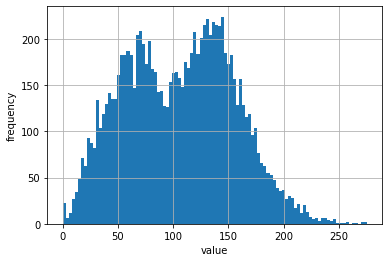

In [301]:
plt.hist(S[-1], bins=100)
plt.xlabel('value')
plt.ylabel('frequency')
plt.grid(True)

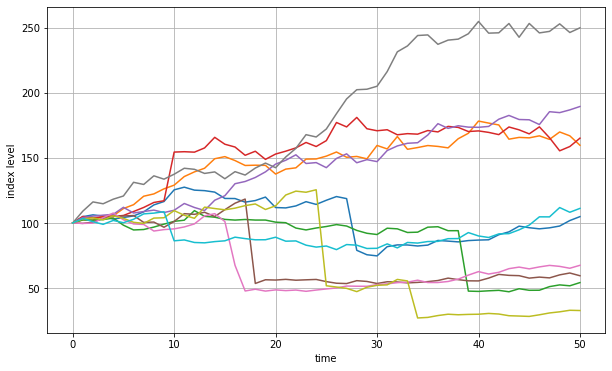

In [303]:
plt.figure(figsize=(10,6))
plt.plot(S[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)
# Observe the sudden jumps in the simulated paths

In [ ]:
# Compare statistics with standard brwonian to see the vast difference

In [80]:
# Implementing simple trading strategies
# Strategy 1
class SmaSignal(bt.Signal):
     params = (('period', 30), )
     def __init__(self):
         self.lines.signal = self.data - bt.ind.SMA(period=self.p.period)

In [81]:
data = yf.download('TSLA', 
                      start='2021-01-01', 
                      end='2021-11-10',
                      progress=False,
                      auto_adjust=True)

data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-12-31,699.989990,718.719971,691.119995,705.669983,49649900
2021-01-04,719.460022,744.489990,717.190002,729.770020,48638200
2021-01-05,723.659973,740.840027,719.200012,735.109985,32245200
2021-01-06,758.489990,774.000000,749.099976,755.979980,44700000
2021-01-07,777.630005,816.989990,775.200012,816.039978,51498900


In [82]:
data = bt.feeds.PandasData(dataname=data)

In [83]:
cerebro = bt.Cerebro(stdstats = False)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.add_signal(bt.SIGNAL_LONG, SmaSignal)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [84]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run(maxcpus=8)
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Final Portfolio Value: 1295.17


In [87]:
cerebro.plot(iplot=True, volume=False)

[[<Figure size 540x360 with 3 Axes>]]

In [105]:
# Strategy 2
class RsiSignalStrategy(bt.SignalStrategy):
     params = dict(rsi_periods=14, rsi_upper=70,
     rsi_lower=30, rsi_mid=55)
     def __init__(self):
         rsi = bt.indicators.RSI(period=self.p.rsi_periods,
         upperband=self.p.rsi_upper,
         lowerband=self.p.rsi_lower)
         bt.indicators.RSI(self.data, plotname='TA_RSI')
         rsi_signal_long = bt.ind.CrossUp(rsi, self.p.rsi_lower,
         plot=False)
         self.signal_add(bt.SIGNAL_LONG, rsi_signal_long)
         self.signal_add(bt.SIGNAL_LONGEXIT, -(rsi >
         self.p.rsi_mid))
         rsi_signal_short = -bt.ind.CrossDown(rsi, self.p.rsi_upper,
         plot=False)
         self.signal_add(bt.SIGNAL_SHORT, rsi_signal_short)
         self.signal_add(bt.SIGNAL_SHORTEXIT, rsi < self.p.rsi_mid)

In [106]:
data = yf.download('FB', 
                      start='2021-01-01', 
                      end='2021-11-10',
                      progress=False,
                      auto_adjust=True)
data = bt.feeds.PandasData(dataname=data)

In [107]:
cerebro = bt.Cerebro(stdstats = False)
cerebro.addstrategy(RsiSignalStrategy)
cerebro.adddata(data)
cerebro.broker.setcash(1000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)

In [108]:
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run(maxcpus=8)
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

Starting Portfolio Value: 1000.00
Final Portfolio Value: 1047.58


<IPython.core.display.Javascript object>


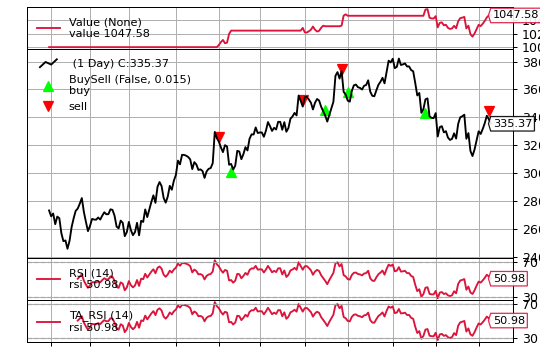

[[<Figure size 432x288 with 4 Axes>]]

In [109]:
cerebro.plot(iplot=True, volume=False)